In [88]:
%config Completer.use_jedi = False
import plotly.express as px
from typing import List
width = 1280
height = 720
import pandas as pd
import multiprocessing
import json
from collections import namedtuple

In [145]:
AnalysisData = namedtuple("AnalysisData", ["input", "num_threads", "iter", "forward_pass_time", "backward_pass_time", "original_size", "compressed_size", "bytes_saved", "percent_of_original", "total_time"])

def amdahl(su):
    s = multiprocessing.cpu_count()
    p = -1
    p = s * (1 - (1 / su)) / (s - 1)
    return p

def calcspeedup(sequential_avg, parallel_avg):
    return sequential_avg / parallel_avg


def analysisjsonToDF(infilejson: str) -> pd.DataFrame:
    with open(infilejson, 'r') as f:
        dat = json.load(f)
    
    analysisdats = []
    for d in dat:
        lines = d[3].split('\n')
        analysisdats.append(AnalysisData(
            d[0], #input
            d[1], # num_threads
            d[2], #iter
            lines[2].split()[0], # forward pass time
            lines[5].split()[0], # backward pass time
            # lines[9].split()[-1], # worked?
            int(''.join(filter(str.isdigit, lines[10].split()[-1]))), # original size
            int(''.join(filter(str.isdigit, lines[11].split()[-1]))), # compressed size
            int(lines[12].split()[-1]) if int(lines[12].split()[-1]) < 100000000000000000 else -1, # bytes saved
            lines[13].split()[-1], # percent of original 
            float(lines[15].split()[0]))) # total time
    return pd.DataFrame(data=analysisdats)

def calcamdahlforinput(df: pd.DataFrame, inputfn: str) -> List[float]:
    dfoi = df[df.input == inputfn]
    avgs = []
    for num_thread in set(dfoi.num_threads):
        avgs.append((num_thread, dfoi[dfoi.num_threads == num_thread].total_time.mean()))

    amdahls_list = []
    for i, avg in enumerate(avgs):
        _su = 1
        _p = 0
        if i != 0:
            _su = calcspeedup(avgs[0][1], avg[1])
            _p = amdahl(_su)
        amdahls_list.append((avg[0], _su, _p, avg[1]))
    return amdahls_list


In [146]:
evaldf = analysisjsonToDF('../evalres25k.json')

In [152]:
infile = 'tests/bible.txt'
evaldf[evaldf.input == infile]

,input,num_threads,iter,forward_pass_time,backward_pass_time,original_size,compressed_size,bytes_saved,percent_of_original,total_time
54,tests/bible.txt,1,1,520.169415,93.641238,4047392,1951539,2095853,48.22%,613.820880
55,tests/bible.txt,1,2,520.381280,93.891063,4047392,1951539,2095853,48.22%,614.283664
56,tests/bible.txt,1,3,519.981785,93.942509,4047392,1951539,2095853,48.22%,613.934377
57,tests/bible.txt,2,1,272.744590,49.565114,4047392,1951539,2095853,48.22%,322.319718
58,tests/bible.txt,2,2,272.788570,49.377664,4047392,1951539,2095853,48.22%,322.176341
59,tests/bible.txt,2,3,273.378110,49.592466,4047392,1951539,2095853,48.22%,322.980627
60,tests/bible.txt,4,1,147.779652,26.873085,4047392,1951539,2095853,48.22%,174.659830
61,tests/bible.txt,4,2,147.543645,26.959768,4047392,1951539,2095853,48.22%,174.510840
62,tests/bible.txt,4,3,147.392164,26.923441,4047392,1951539,2095853,48.22%,174.322690
63,tests/bible.txt,8,1,139.631517,41.282169,4047392,1951539,2095853,48.22%,180.921879


(1, 1, 0, 614.0129736666667)
(2, 1.9039620774903097, 0.5426050914278467, 322.4922286666667)
(4, 3.518743620740481, 0.818065891763765, 174.49778666666666)
(8, 3.3864793096313983, 0.8053806552238736, 181.313074)
(12, 3.4461935136712123, 0.8112283070638612, 178.17135666666664)
(16, 3.342859236157306, 0.8009770150624459, 183.67897966666666)


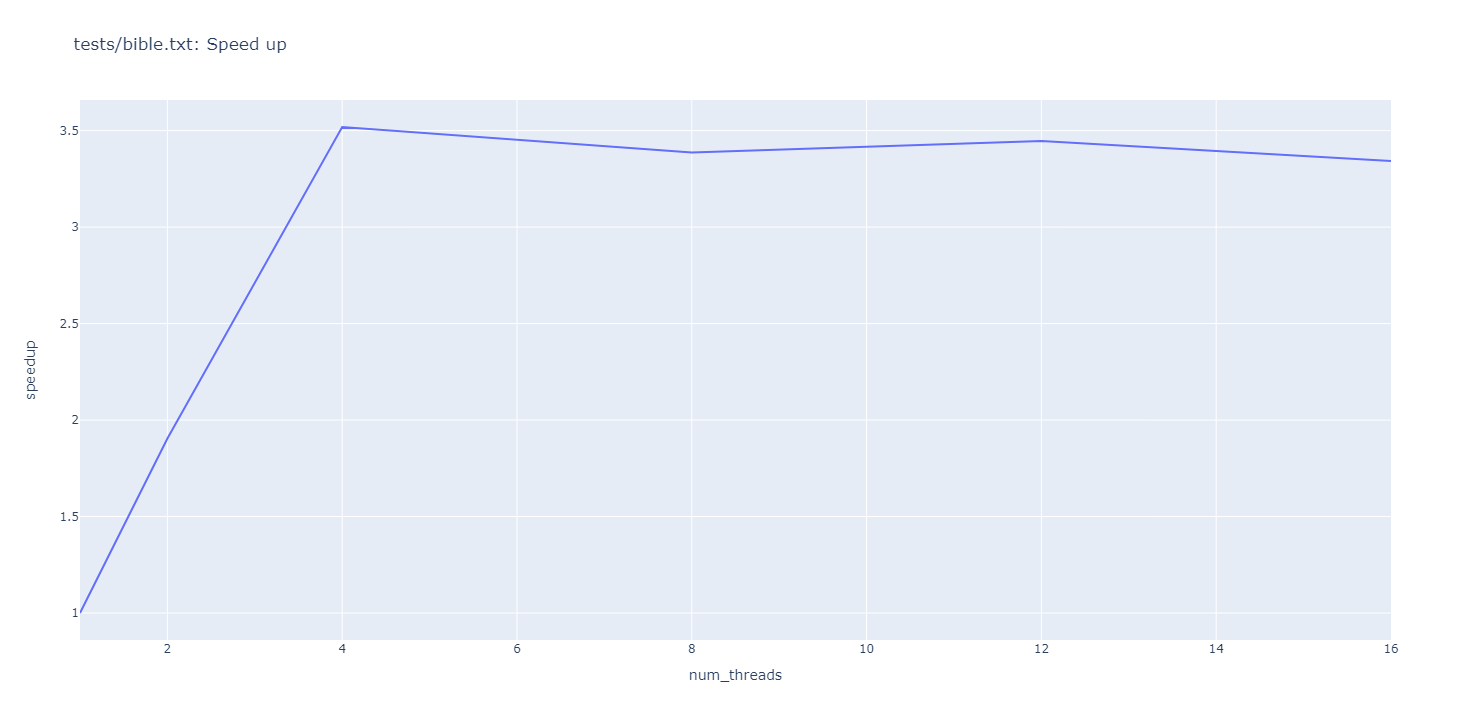

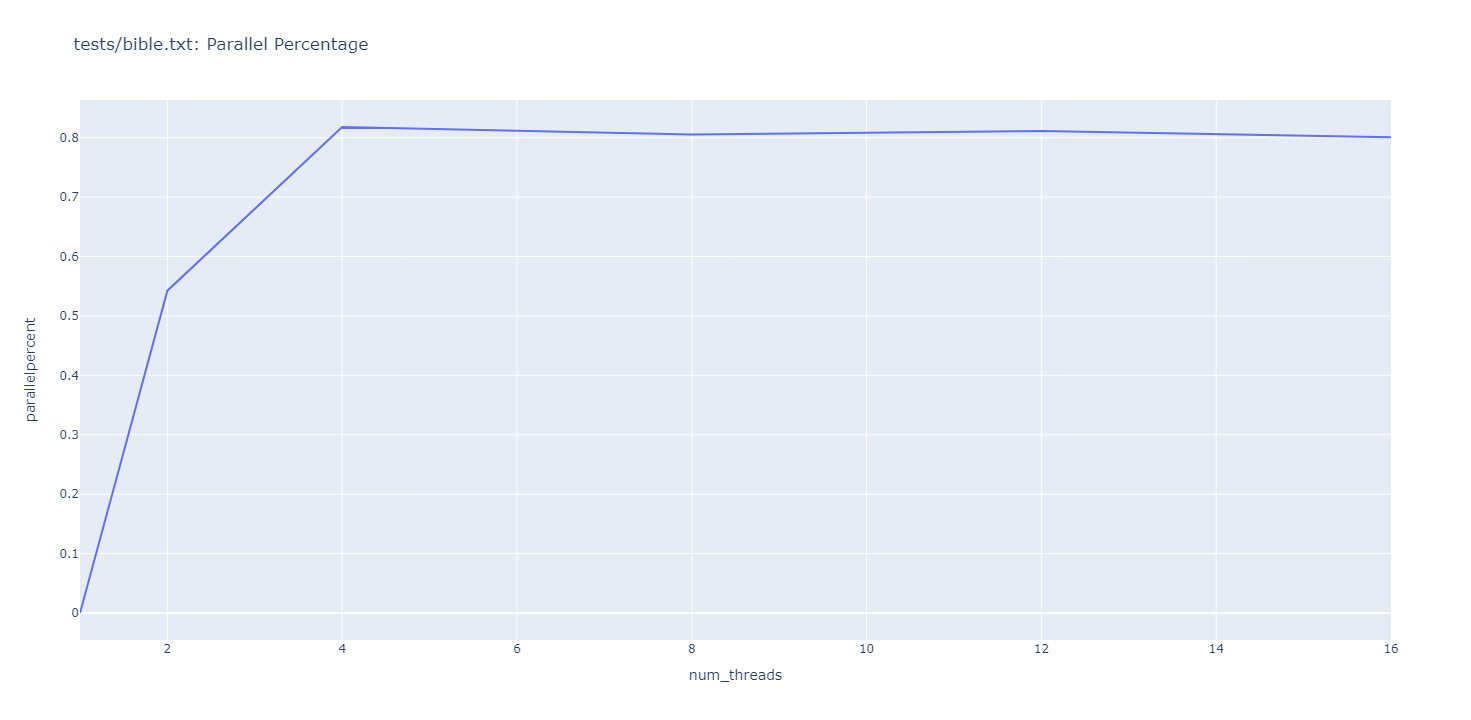

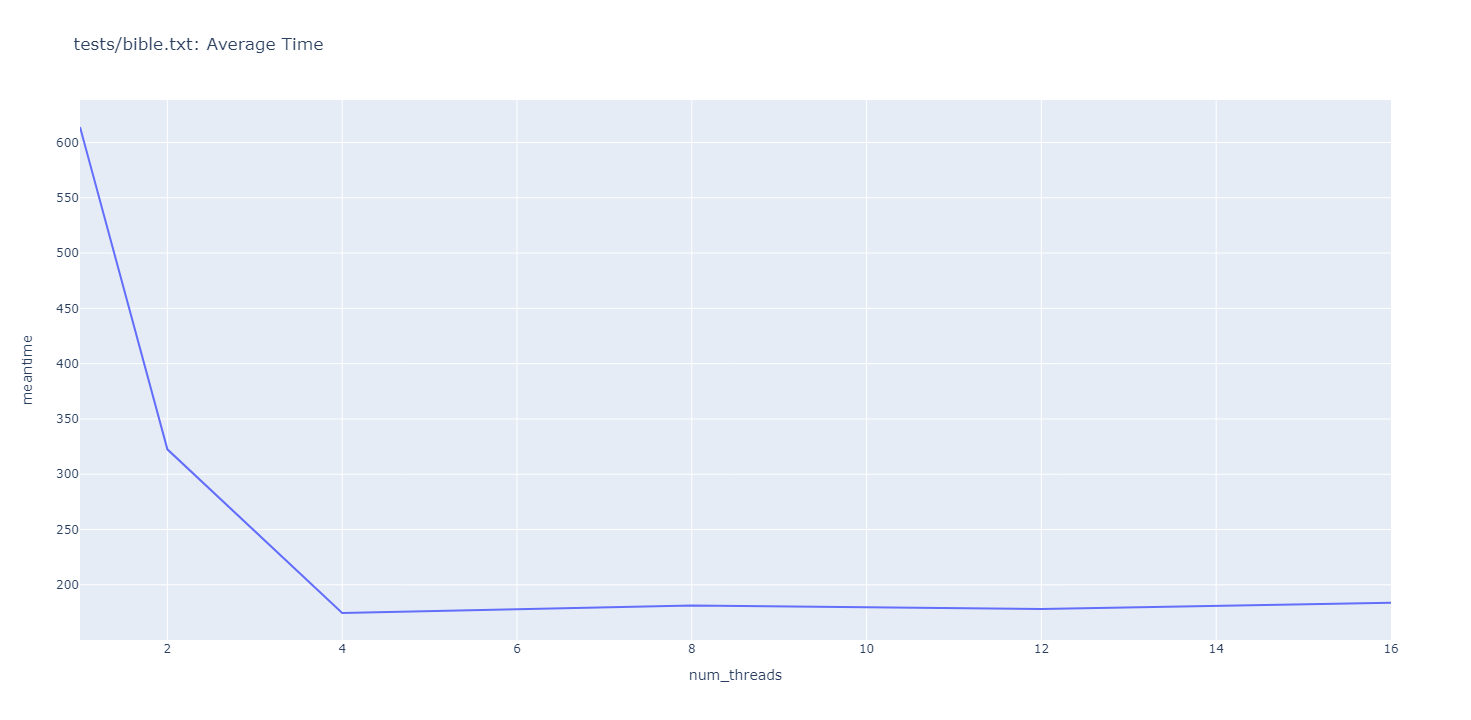

In [153]:
amdahs_ = calcamdahlforinput(evaldf, infile)
[print(n) for n in amdahs_]
amdf = pd.DataFrame(amdahs_, columns=["num_threads", "speedup", "parallelpercent", "meantime"])
fig = px.line(amdf, x="num_threads", y="speedup", height=height, width=width, title=f"{infile}: Speed up")
fig.show()
fig = px.line(amdf, x="num_threads", y="parallelpercent", height=height, width=width, title=f"{infile}: Parallel Percentage")
fig.show()
fig = px.line(amdf, x="num_threads", y="meantime", height=height, width=width, title=f"{infile}: Average Time")
fig.show()